In [11]:
# Importing required libraries
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, filters
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from skimage.feature import hog
from sklearn.decomposition import PCA
from skimage.transform import resize
from skimage import img_as_ubyte

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Code Snippet 1: Function to get bounding boxes from Annotations
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

In [3]:
# Code Snippet 2: Cropping and Resizing Images
def process_images(dog_images, annotations):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = io.imread(dog_images[i])
        for j in range(len(bbox)):
            im2 = dog[bbox[j][1]:bbox[j][3], bbox[j][0]:bbox[j][2]]

            # Check if the cropped region is not empty before resizing
            if im2.size > 0:
                im2 = resize(im2, (128, 128), anti_aliasing=True)
                im2 = img_as_ubyte(im2)

                new_path = dog_images[i].replace('rajani images', 'Cropped').replace('.jpg', f'-{j}.jpg')

                # Create the directory if it doesn't exist
                os.makedirs(os.path.dirname(new_path), exist_ok=True)

                io.imsave(new_path, im2)

In [4]:
dog_images_folder = 'rajani images'
annotations_folder = 'rajani annotations'
dog_images = {}
annotations = {}

# Load images and annotations
for folder_name in os.listdir(dog_images_folder):
    folder_path = os.path.join(dog_images_folder, folder_name)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]
    dog_images[folder_name] = images

for folder_name in os.listdir(annotations_folder):
    folder_path = os.path.join(annotations_folder, folder_name)
    annotations[folder_name] = [os.path.join(folder_path, annot) for annot in os.listdir(folder_path)]

In [7]:
dog_images.keys()

dict_keys(['n02093991-Irish_terrier', 'n02098413-Lhasa', 'n02102480-Sussex_spaniel', 'n02105412-kelpie'])

In [8]:
process_images(dog_images['n02105412-kelpie'], annotations['n02105412-kelpie'])

In [9]:
process_images(dog_images['n02093991-Irish_terrier'], annotations['n02093991-Irish_terrier'])
process_images(dog_images['n02098413-Lhasa'], annotations[ 'n02098413-Lhasa'])
process_images(dog_images['n02102480-Sussex_spaniel'], annotations['n02102480-Sussex_spaniel'])

In [10]:
crop_folder=r'Cropped'


In [19]:
def edge_histogram(selected_images):
    ims=[]
    dogs=[]
    for idx, path in enumerate(selected_images):
        img_path = os.path.join(crop_folder,path)
        for im in os.listdir(img_path):
            src = os.path.join(img_path, im)
            img = io.imread(src)
            gray_img = color.rgb2gray(img)
            dx, dy = filters.sobel_h(gray_img), filters.sobel_v(gray_img)
            angle_sobel = np.mod(np.arctan2(dy, dx), np.pi)
            hist, bins = exposure.histogram(angle_sobel, nbins=36)
            ims.append(hist)
            dogs.append(idx)
    return ims,dogs

In [28]:
ims,dogs=edge_histogram(os.listdir(crop_folder))

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(np.array(ims),np.array(dogs), test_size=0.2,stratify=dogs, random_state=42)
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold ,KFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier


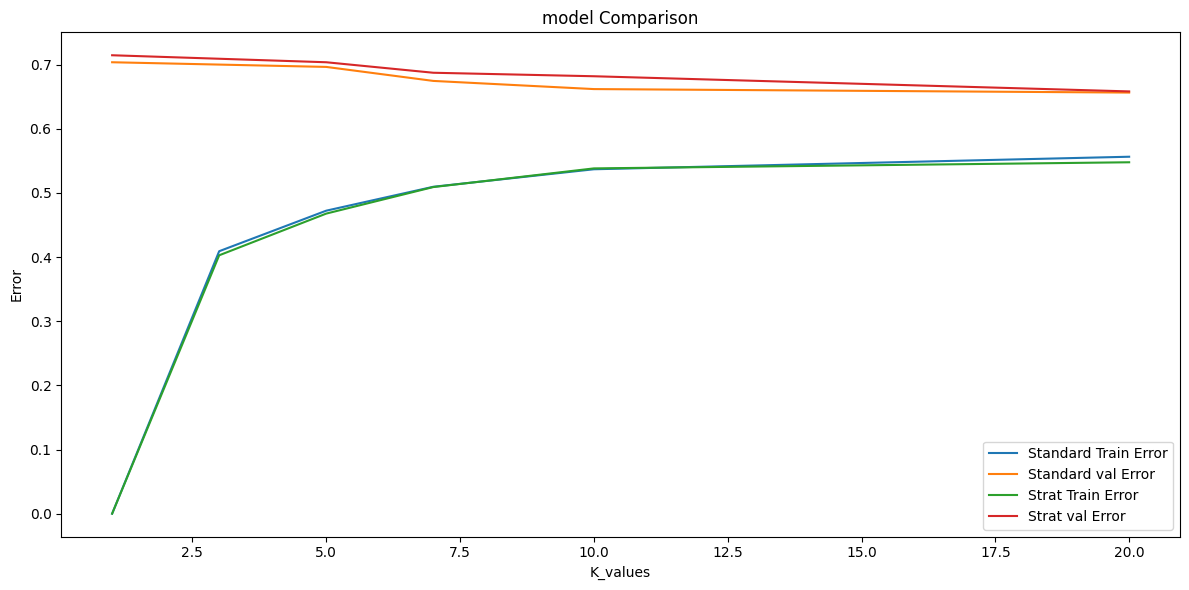

In [32]:
k_values = [1,3,5,7,10,20]

def Model_Selection(fold):
    train_errors,val_errors =[],[]
    for k in [1,3,5,7,10,20]:
        KNN = KNeighborsClassifier(k)
        train,val = [],[]
        for train_index, test_index in fold.split(X_train, y_train):
            xtrain, xval = X_train[train_index], X_train[test_index]
            ytrain, yval = y_train[train_index], y_train[test_index]
            KNN.fit(xtrain, ytrain)
            train_pred = KNN.predict(xtrain)
            val_pred = KNN.predict(xval)
            train_acc = accuracy_score(ytrain, train_pred)
            val_acc = accuracy_score(yval, val_pred)
            train.append(1-train_acc)
            val.append(1-val_acc)
        train_errors.append(np.mean(train))
        val_errors.append(np.mean(val))
    return train_errors,val_errors
def plot_KNN():
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, standardtrain, label='Standard Train Error')
    plt.plot(k_values, standardval, label='Standard val Error')
    plt.plot(k_values, strattrain, label='Strat Train Error')
    plt.plot(k_values, stratval, label='Strat val Error')
    plt.xlabel('K_values')
    plt.ylabel('Error')
    plt.title('model Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
standardtrain,standardval = Model_Selection(KFold(n_splits=5))
strattrain,stratval= Model_Selection(StratifiedKFold(n_splits=5))
plot_KNN()

the lowest mean error : Standard Training error      at k=1 
                        stratified Training error    at k=1 
                        standard validation error    at k=10
                        stratified validation error  at k=20

the model complexity : Less         at k = 1
                       Intermidiate at k = 3,5,7,10
                       high         at k = 20
 

model :  overfits at k = 1   training error is less validation is more.
        underfits at k =20   Great number of neighbours

In [33]:
#Test error 
KNN =KNeighborsClassifier(20)
KNN.fit(X_train,y_train)
err=1-accuracy_score(y_test,KNN.predict(X_test))
print(err)

0.7101449275362319


In [38]:
#https://stackoverflow.com/questions/67636940/confusionmatrixdisplay-scikit-learn-plot-labels-out-of-range
def performance_comparision(assigned_classifiers):
    for classifier in assigned_classifiers:
        print(classifier)
        Actual,predicted,validation,confu_matrx=[],[],[],[]
        for train_index, test_index in StratifiedKFold(n_splits=5).split(X_train, y_train):
            xtrain, xval = X_train[train_index], X_train[test_index]
            ytrain, yval = y_train[train_index], y_train[test_index]
        
            classifier.fit(xtrain, ytrain)
            pred= classifier.predict(xval)
            Actual.extend(yval)
            predicted.extend(pred)
            vala = accuracy_score(yval, pred)
            validation.append(vala)
        print("MeanValAccuracy : "+str(np.mean(validation)))
        sub= classifier.predict(X_test)
        test_accuracy = accuracy_score(y_test,sub)
        print("TestAcc : "+str(test_accuracy))
        f1 = f1_score(y_test, sub, average='weighted')
        print("f1:"+str(f1))
        confu_matrx.append(confusion_matrix(Actual, predicted))
        cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(confu_matrx)/len(confu_matrx), display_labels = os.listdir(crop_folder))
        cm_display.plot(xticks_rotation=70)
        plt.show()

MLPClassifier(hidden_layer_sizes=(10, 10, 10))
MeanValAccuracy : 0.3254545454545455
TestAcc : 0.34782608695652173
f1:0.33161541180629195


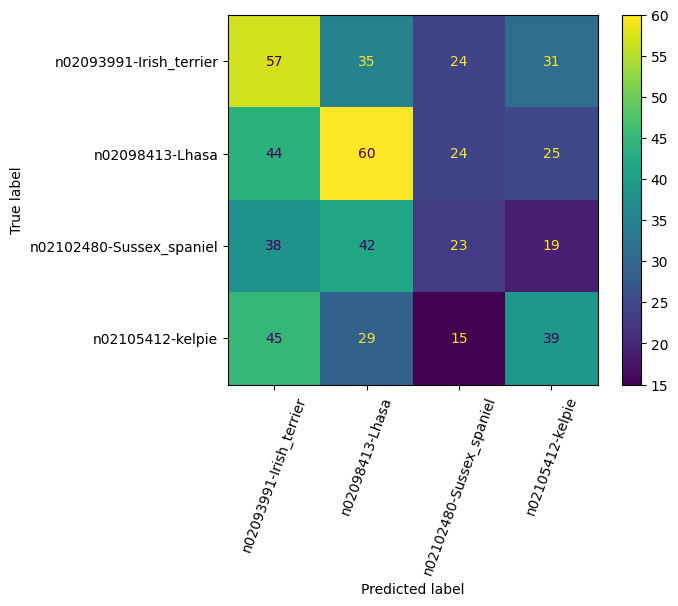

LinearSVC()
MeanValAccuracy : 0.3654545454545455
TestAcc : 0.32608695652173914
f1:0.32326026184875906


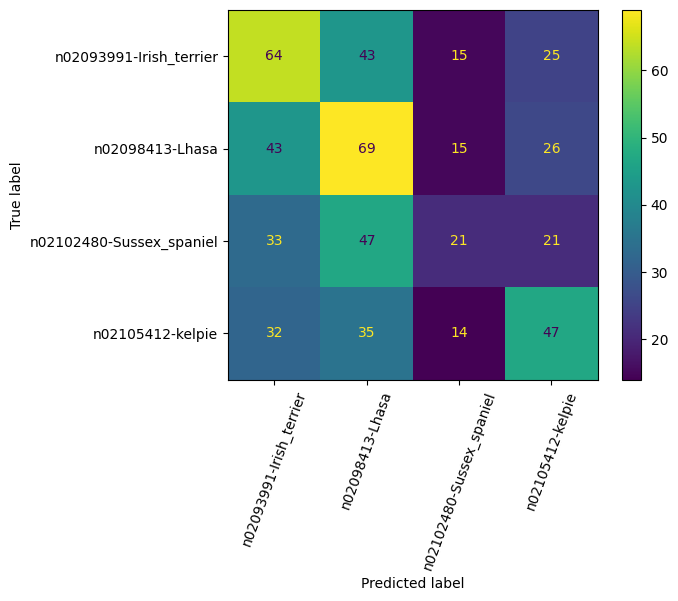

AdaBoostClassifier()
MeanValAccuracy : 0.3618181818181818
TestAcc : 0.3188405797101449
f1:0.3191372616575269


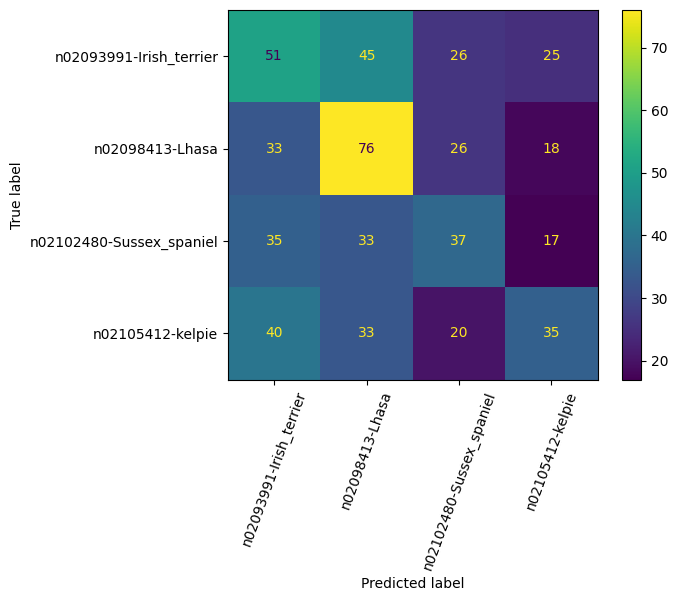

In [39]:
assigned_classifiers=[MLPClassifier(hidden_layer_sizes=(10,10,10)),LinearSVC(),AdaBoostClassifier()]
performance_comparision(assigned_classifiers)